### Useful libraries

In [1]:
import pandas as pd  # table management
import numpy as np  # Matlab-like matrix operations

import plotly  # pretty interactive plots (on website)
import plotly.express as px

import matplotlib.pyplot as plt  # quick plots
import seaborn as sns  # more pretty plots

import sklearn  # machine learning

import logging  # logging info, warnings and errors

from pkg_resources import resource_listdir, resource_stream  # loading raw files

### Useful imports from our package

In [2]:
import coronus_web
from coronus_web.loading.frames import get_cases  # for loading preprocessed cases (already preprocessed)
from coronus_web.plotting.plots import plot_interactive_df  # for plotting a dataframe
from coronus_web.loading.download import get_frames
from coronus_web.loading.download import GEO_LEVELS, CASE_TYPES  # constants

### Or get our preprocessed cases

In [238]:
geo_level = "country"
total = get_cases(geo_level, "total")
active = get_cases(geo_level, "active")
deaths = get_cases(geo_level, "deaths")
recovered = get_cases(geo_level, "recovered")

In [6]:
# active = active.resample("D").interpolate(method="time")
active = active.rolling(5).mean()

In [5]:
# np.log(active.loc["2020-02-07":,"Diamond Princess"]).diff(5)

In [340]:
smooth = 10
features = pd.concat(
    [
        np.log(active).stack().rename("log_active"),
        np.log(active).diff(1).stack().rename("log_growth")/1,
        np.log(active).diff(3).stack().rename("log_growth_3")/3,
        np.log(active).diff(5).stack().rename("log_growth_5")/5,
        np.log(active).diff(10).stack().rename("log_growth_10")/10,
        
        np.log(deaths).stack().rename("log_deaths"),
        (np.log(recovered) - np.log(deaths)).stack().rename("log_recovered_deaths")
    ],
    axis=1
)
features = features.sort_index()
features = features.replace([-np.inf, np.inf], np.nan).fillna(method="backfill")
features_scaled = features.dropna()
features_scaled

/home/ira/code/envs/flexi/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning:

divide by zero encountered in log

/home/ira/code/envs/flexi/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning:

divide by zero encountered in log



log_active  log_growth  log_growth_3  \
date       country                                                    
2020-01-22 Afghanistan           6.220590    0.167971      0.322859   
           Albania               6.220590    0.167971      0.322859   
           Algeria               6.220590    0.167971      0.322859   
           Andorra               6.220590    0.167971      0.322859   
           Angola                6.220590    0.167971      0.322859   
...                                   ...         ...           ...   
2020-03-28 Uruguay               5.613128    0.140857      0.123794   
           Uzbekistan            4.574711    0.167992      0.160122   
           Venezuela             4.356709    0.039221      0.008658   
           Vietnam               5.030438    0.067593      0.070052   
           West Bank and Gaza    4.369448    0.078988      0.210593   

                               log_growth_5  log_growth_10  log_deaths  \
date       country                                                       
2020-01-22 Afghanistan             0.338806       0.311700    2.833213   
           Albania                 0.338806       0.311700    2.833213   
           Algeria                 0.338806       0.311700    2.833213   
           Andorra                 0.338806       0.311700    2.833213   
           Angola                  0.338806       0.311700    2.833213   
...                                     ...            ...         ...   
2020-03-28 Uruguay                 0.105106       0.170111    0.693147   
           Uzbekistan              0.149214       0.186666    0.693147   
           Venezuela               0.045915       0.077319    0.693147   
           Vietnam                 0.073400       0.095290    0.000000   
           West Bank and Gaza      0.126356       0.065588    0.000000   

                               log_recovered_deaths  
date       country                                   
2020-01-22 Afghanistan                     0.498991  
           Albania                         0.498991  
           Algeria                         0.498991  
           Andorra                         0.498991  
           Angola                          0.498991  
...                                             ...  
2020-03-28 Uruguay                         0.916291  
           Uzbekistan                      0.916291  
           Venezuela                       2.970414  
           Vietnam                         2.890372  
           West Bank and Gaza              2.890372  

[11857 rows x 7 columns]

In [341]:
features_scaled = (features_scaled - features_scaled.mean())/features_scaled.std()

In [342]:
# fig = px.scatter_matrix(
#     features.sample(100).reset_index(),
#     dimensions=features.columns,
#     color=geo_level,
# )
# fig.show()

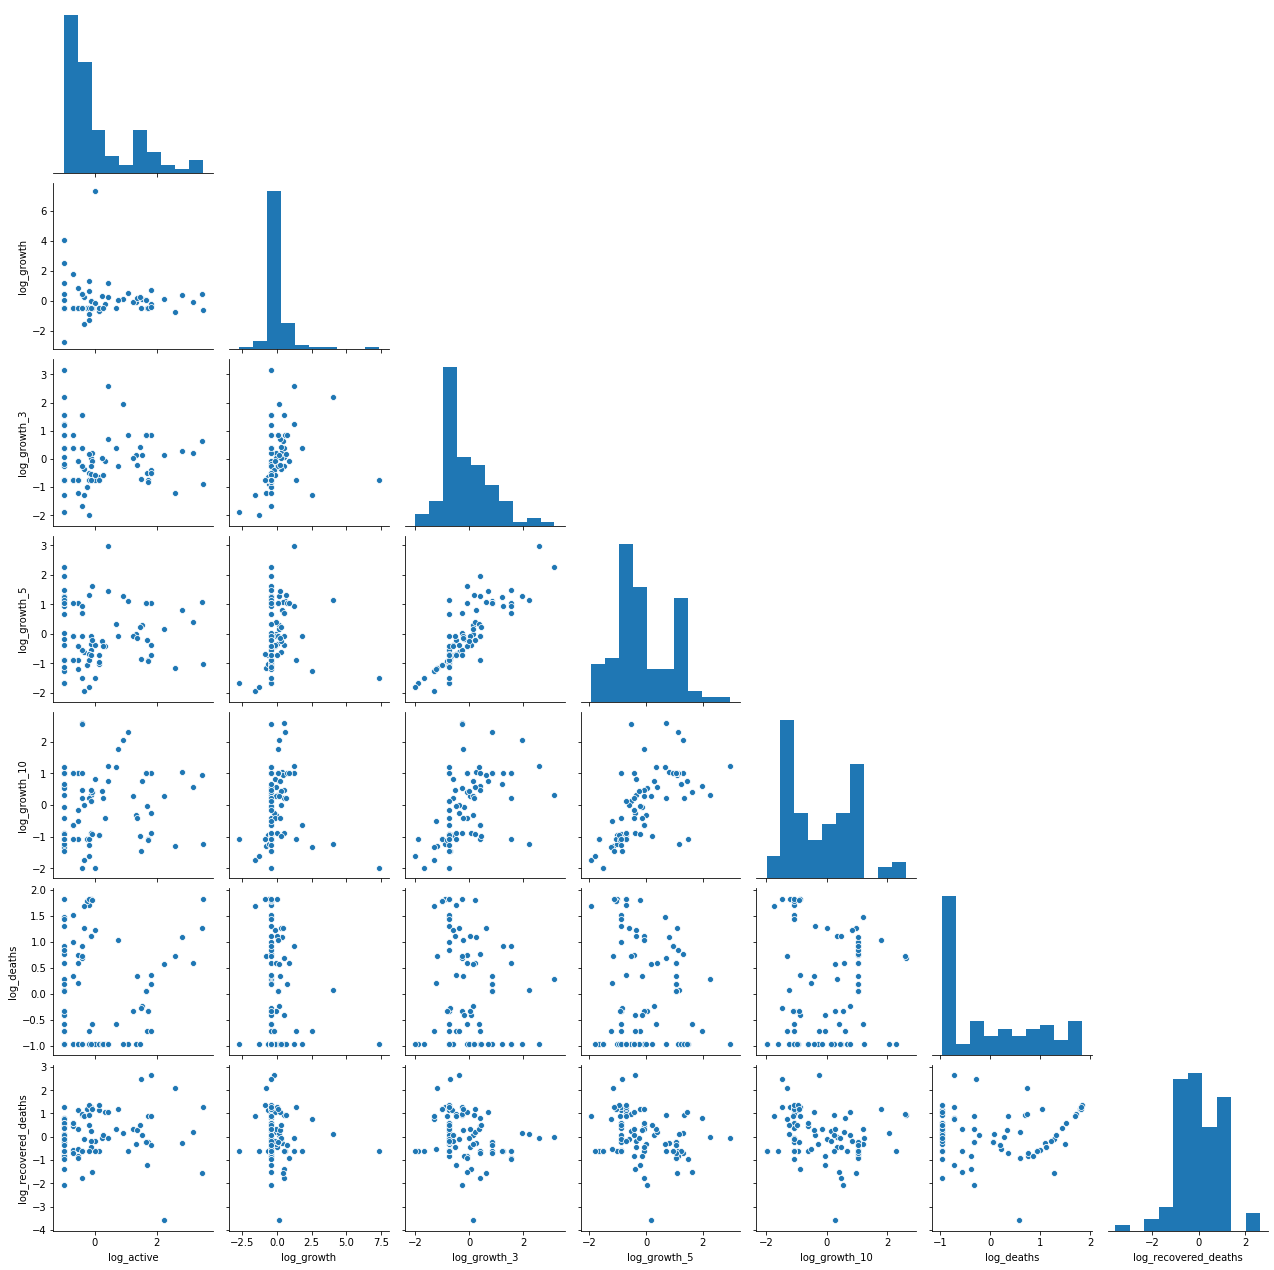

In [343]:
sns.pairplot(
    features_scaled.sample(100).reset_index(),
    vars=features.columns,
#     hue=geo_level,
#     diag_kind="kde",
#     kind="reg",
    corner=True
)

# Split data into train and test

In [344]:
train = features_scaled.loc[:"2020-02-28"]
test = features_scaled.loc["2020-03-01":"2020-03-20"]

## Encoding

- PCA

In [345]:
from sklearn.decomposition import PCA

In [346]:
encoder = PCA(n_components=5)

In [347]:
encoder.fit(train)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [348]:
encoder.explained_variance_ratio_

array([0.45548245, 0.19580039, 0.13608552, 0.09795821, 0.06100987])

In [349]:
train_encoding = pd.DataFrame(encoder.transform(train), index=train.index)
test_encoding = pd.DataFrame(encoder.transform(test), index=test.index)

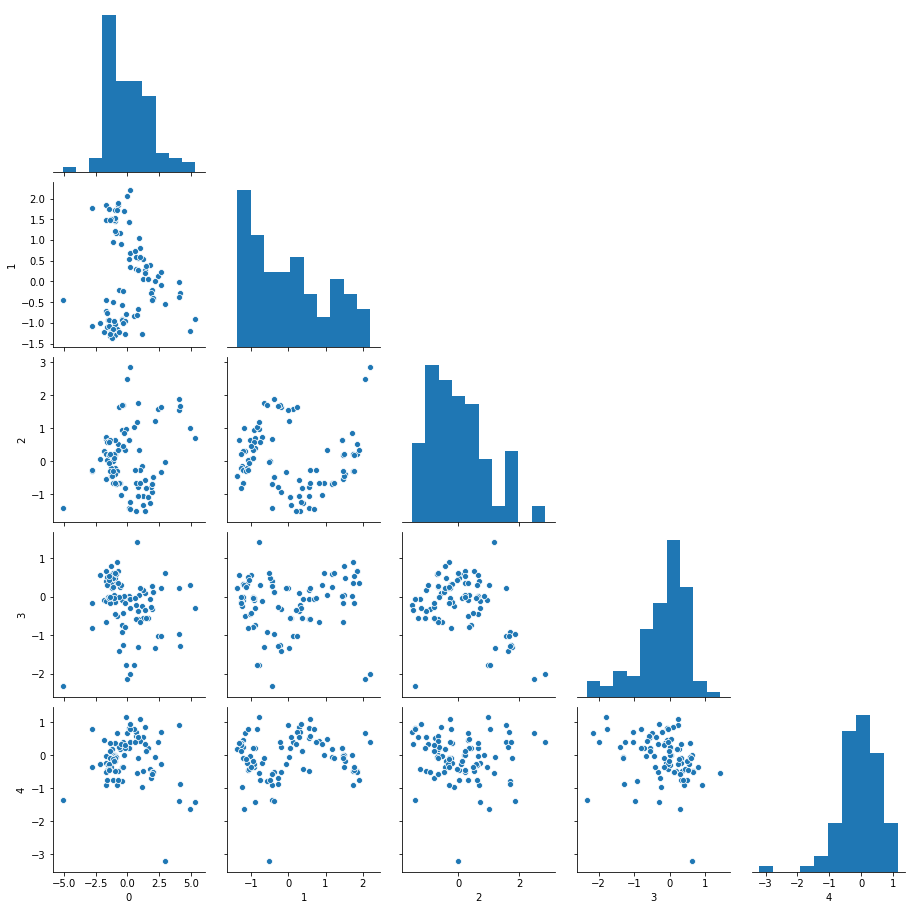

In [350]:
sample = train_encoding.sample(100)
sns.pairplot(
    sample.reset_index(),
    vars=sample.columns,
#     hue=geo_level,
    corner=True
)

In [351]:
from sklearn.neighbors import NearestNeighbors

In [352]:
nn = NearestNeighbors(n_neighbors=5)
nn.fit(train_encoding)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [353]:
guy = test_encoding.sample(1)
ds, neighs = nn.kneighbors(np.atleast_2d(guy.values))
test.loc[guy.index]

,,log_active,log_growth,log_growth_3,log_growth_5,log_growth_10,log_deaths,log_recovered_deaths
date,country,,,,,,,
2020-03-20,Netherlands,2.331226,0.166767,0.168025,0.20556,0.290709,0.683803,-3.86096


In [362]:
neighs.flatten().tolist()

[6457, 6458, 6460, 6459, 6636]

In [354]:
histories = train.iloc[neighs.flatten().tolist()].index.to_frame().reset_index(drop=True)
histories["date_end"] = histories["date"] + pd.DateOffset(14)

In [355]:
histories

,date,country,date_end
0,2020-02-27,Jordan,2020-03-12
1,2020-02-27,Kazakhstan,2020-03-12
2,2020-02-27,"Korea, South",2020-03-12
3,2020-02-27,Kenya,2020-03-12
4,2020-02-28,Kenya,2020-03-13


In [356]:
# sections = []
# for i, (date_start, region, date_end) in histories.iterrows():
#     a = features.loc[(slice(date_start, date_end), region), "log_growth"].rename(str(date_start.date()) + "-" + region)
#     sections.append(a)

In [357]:
sections = [
    features.loc[(slice(date_start, date_end), region), "log_growth"]
    .rename(str(date_start.date()) + "-" + region)
    .reset_index(drop=True)
    for i, (date_start, region, date_end) in histories.iterrows()
]

In [358]:
sims = pd.concat(sections, axis=1)
sims["prediction"] = sims.mean(axis=1)

In [359]:
true_range = guy.index.to_frame().reset_index(drop=True)
true_range["date_end"] = true_range["date"] + pd.DateOffset(14)
date_start, region, date_end = true_range.iloc[0].values
sims["truth"] = features.loc[(slice(date_start, date_end), region), "log_growth"].reset_index(drop=True)

In [360]:
# plot_interactive_df(sims)
np.exp((sims).cumsum())

,2020-02-27-Jordan,2020-02-27-Kazakhstan,"2020-02-27-Korea, South",2020-02-27-Kenya,2020-02-28-Kenya,prediction,truth
0,1.410758,1.410758,1.410758,1.410758,1.329867,1.394195,1.211893
1,1.876121,1.876121,1.876121,1.876121,1.794916,1.859591,1.466080
2,2.532192,2.532192,2.532192,2.532192,2.131138,2.446356,1.689698
3,3.006520,3.006520,3.006520,3.006520,2.470826,2.890811,1.904523
4,3.485738,3.485738,3.485738,3.485738,2.962449,3.374162,2.219430
5,4.179299,4.179299,4.179299,4.179299,3.203351,3.962814,2.544807
6,4.179299,4.519152,4.519152,4.519152,3.473137,4.220844,2.942630
7,4.179299,4.899756,4.899756,4.899756,3.706528,4.488682,3.389447
8,4.179299,5.229014,5.229014,5.229014,3.964183,4.730459,3.841290
9,4.179299,5.592502,5.592502,5.592502,4.128250,4.965209,NaN


In [361]:
plot_interactive_df(sims[["prediction", "truth"]])

In [317]:
test.loc[guy.index]

,,log_growth
date,country,
2020-03-17,Ecuador,0.908807
